In [1]:
import random as rd
import numpy as np
from time import time
import matplotlib.pyplot as plt

## Define Sites

In [2]:
class site:
    def __init__(self,lattice,x,y,z):
        self.x = x
        self.y = y
        self.z = z
        self.lattice = lattice

    def setspin(self,s):
        self.spin = s
    
    def setrandomspin(self): # set random spin for this site
        self.spin = rd.choice([-1,1]) # set spin = -1 or 1
     
    def getspin(self):
        return self.spin

    def flipspin(self):
        self.spin *= -1

    def getposition(self):
        return np.array([self.x,self.y,self.z])

    def getzeemanenergy(self,B):
        g = 2.0
        muB = 5e-2 #mev/T
        return -g*muB*self.getspin()*B

    def getdeltaexchangeenergy(self,J):
        E = 0
        NN = self.getnearestneighbourscubic()
        for nn in NN:
            E += -J*self.spin*nn.spin
        return E

    def getlistposition(self,x,y,z):
        return x*self.lattice.N2*self.lattice.N3 + y*self.lattice.N3 + z

    def getnearestneighbourscubic(self):
        #i-1 i+1, j-1 j+1, k-1 k+1 with periodic boundary conditions
        NN1 = self.lattice.sites[self.getlistposition((self.x-1) % self.lattice.N1, self.y, self.z)]
        NN2 = self.lattice.sites[self.getlistposition((self.x+1) % self.lattice.N1, self.y, self.z)]
        NN3 = self.lattice.sites[self.getlistposition(self.x, (self.y-1) % self.lattice.N1, self.z)]
        NN4 = self.lattice.sites[self.getlistposition(self.x, (self.y+1) % self.lattice.N1, self.z)]
        NN5 = self.lattice.sites[self.getlistposition(self.x, self.y, (self.z-1) % self.lattice.N1)]
        NN6 = self.lattice.sites[self.getlistposition(self.x, self.y, (self.z+1) % self.lattice.N1)]
        return [NN1,NN2,NN3,NN4,NN5,NN6]

## Define Lattice

In [3]:
class lattice:
    def __init__(self,N1,N2,N3):
        self.N1 = N1 # Dimension of the lattice
        self.N2 = N2
        self.N3 = N3
        self.sites = [] # Creating a list to take in the information of sites

    def populatesites(self):
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    self.sites.append(site(lat,i,j,k)) # Assign each site a coordianate

    def initialisespins(self): # Set spin for each site
        for i in range(self.N1*self.N2*self.N3):
            self.sites[i].setrandomspin()

    def getlistposition(self,x,y,z):
        return x*self.N2*self.N3 + y*self.N3 + z
            
    def gettotalenergy1(self,J):
        E = 0 #meV
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition(i, j, (k+1)% self.N3)].getspin()
        
        for i in range(self.N1):
            for k in range(self.N3):
                for j in range(self.N2):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition(i, (j+1)% self.N2, k)].getspin()
                
        for j in range(self.N2):
            for k in range(self.N3):
                for i in range(self.N1):
                    E += -J*self.sites[self.getlistposition(i, j, k)].getspin() * self.sites[self.getlistposition((i+1)% self.N1, j, k)].getspin()
                
        return E
    
    def pickrandomsite(self):
        site_f = rd.randrange(self.N1*self.N2*self.N3)
        return site_f
    
    def filpspin(self,site_f):
        self.sites[site_f].flipspin()
    
    def plotDvM(self,MCS,data,dataname):
        MCS_plot = np.arange(0,MCS)
        plt.close('all')
        plt.figure()
        plt.plot(MCS_plot,data,'ok')
        plt.xlabel('MC Accepts')
        plt.ylabel(dataname)
        plt.show()
    
    def plotEvT(self,E,T):
        plt.close('all')
        plt.figure()
        plt.plot(T,E,'ok')
        plt.xlabel('Temperature')
        plt.ylabel('Energy')
        plt.show()

In [4]:
starttime = time()

MCS = 100 # MC steps per temperature
J = 100 # meV
T = 200 # Kelvin
T_p = 0.92
kB = 8.617e-2 # meV/K

MCA_plot = []
T_plot = []
E_plot = []

# set up the sites
lat = lattice(10,10,10) # set up the size of lattice
lat.populatesites()     # Assign each site a coordinate
lat.initialisespins()   # Assign each site a random spin
E_0 = lat.gettotalenergy1(J) # get initial total energy of the system
E_t = E_0

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    
    for i in range(MCS):
        fs = lat.pickrandomsite() # pick a random site to flip its spin
        lat.filpspin(fs) # flip spin
        dE = lat.sites[fs].getdeltaexchangeenergy(J)*2

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_t += dE
            MCA += 1 # MC Accepts
            
        else:
            lat.filpspin(fs) # flip the spin back
    
    print('%.2f  %d' %(T, MCA))
    MCA_plot.append(MCA)
    T_plot.append(T)
    E_plot.append(E_t)
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

200.00  64
184.00  59
169.28  51
155.74  47
143.28  48
131.82  46
121.27  39
111.57  30
102.64  28
94.43  37
86.88  28
79.93  33
73.53  23
67.65  30
62.24  26
57.26  17
52.68  17
48.46  25
44.59  30
41.02  25
37.74  28
34.72  13
31.94  21
29.39  18
27.04  16
24.87  18
22.88  18
21.05  18
19.37  12
17.82  16
16.39  17
15.08  18
13.88  15
12.77  11
11.74  14
10.80  19
9.94  18
9.14  16
8.41  14
7.74  16
7.12  9
6.55  19
6.03  10
5.55  13
5.10  14
4.69  12
4.32  12
3.97  14
3.65  12
3.36  12
3.09  9
2.85  12
2.62  6
2.41  8
2.22  15
2.04  20
1.88  15
1.73  15
1.59  17
1.46  16
1.34  13
1.24  13
1.14  13
1.05  17
0.96  10
0.89  10
0.81  10
0.75  7
0.69  10
0.63  14
0.58  12
0.54  8
0.49  5
0.45  10
0.42  12
0.38  4
0.35  11
0.33  4
0.30  5
0.28  10
0.25  14
0.23  12
0.21  5
0.20  10
0.18  10
0.17  6
0.15  13
0.14  4
0.13  6
0.12  19
0.11  7
0.10  10
0.09  5
0.09  11
0.08  4
0.07  9
0.07  5
0.06  3
0.06  3
0.05  2
Runtime:  0.062050


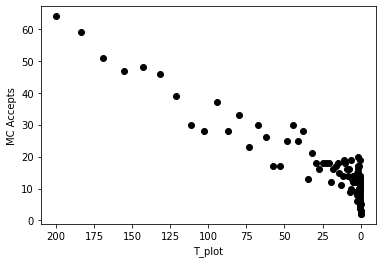

In [13]:
plt.close('all')
plt.figure()
plt.plot(T_plot,MCA_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('MC Accepts')
plt.show()

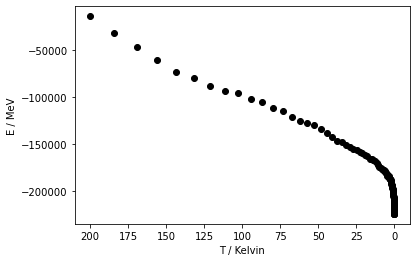

In [15]:
plt.close('all')
plt.figure()
plt.plot(T_plot,E_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('E / MeV')
plt.show()

In [19]:
starttime = time()

MCS = 200 # MC steps per temperature
J = 100 # meV
T = 200 # Kelvin
T_p = 0.92
kB = 8.617e-2 # meV/K

MCA_plot = []
T_plot = []
E_plot = []

# set up the sites
lat = lattice(100,100,100) # set up the size of lattice
lat.populatesites()     # Assign each site a coordinate
lat.initialisespins()   # Assign each site a random spin
E_0 = lat.gettotalenergy1(J) # get initial total energy of the system
E_t = E_0

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    
    for i in range(MCS):
        fs = lat.pickrandomsite() # pick a random site to flip its spin
        lat.filpspin(fs) # flip spin
        dE = lat.sites[fs].getdeltaexchangeenergy(J)*2

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_t += dE
            MCA += 1 # MC Accepts
            
        else:
            lat.filpspin(fs) # flip the spin back
    
    print('%.2f  %d' %(T, MCA))
    MCA_plot.append(MCA)
    T_plot.append(T)
    E_plot.append(E_t)
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

200.00  132
184.00  141
169.28  125
155.74  143
143.28  130
131.82  137
121.27  143
111.57  128
102.64  134
94.43  140
86.88  135
79.93  119
73.53  144
67.65  134
62.24  124
57.26  127
52.68  133
48.46  127
44.59  141
41.02  136
37.74  137
34.72  133
31.94  129
29.39  128
27.04  146
24.87  120
22.88  124
21.05  139
19.37  125
17.82  123
16.39  129
15.08  127
13.88  136
12.77  129
11.74  131
10.80  119
9.94  137
9.14  128
8.41  116
7.74  135
7.12  131
6.55  133
6.03  135
5.55  126
5.10  121
4.69  129
4.32  132
3.97  124
3.65  123
3.36  144
3.09  133
2.85  128
2.62  140
2.41  119
2.22  132
2.04  125
1.88  130
1.73  136
1.59  121
1.46  130
1.34  120
1.24  129
1.14  137
1.05  126
0.96  138
0.89  125
0.81  132
0.75  133
0.69  134
0.63  126
0.58  126
0.54  134
0.49  131
0.45  123
0.42  124
0.38  144
0.35  123
0.33  133
0.30  140
0.28  123
0.25  132
0.23  127
0.21  128
0.20  126
0.18  125
0.17  132
0.15  137
0.14  135
0.13  125
0.12  131
0.11  131
0.10  128
0.09  130
0.09  120
0.08  126
0.07 

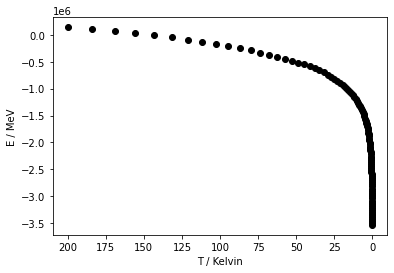

In [20]:
plt.close('all')
plt.figure()
plt.plot(T_plot,E_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('E / MeV')
plt.show()

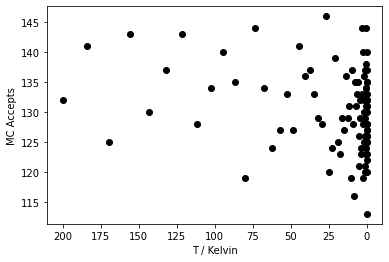

In [21]:
plt.close('all')
plt.figure()
plt.plot(T_plot,MCA_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('MC Accepts')
plt.show()

In [22]:
starttime = time()

MCS = 300 # MC steps per temperature
J = 100 # meV
T = 200 # Kelvin
T_p = 0.92
kB = 8.617e-2 # meV/K

MCA_plot = []
T_plot = []
E_plot = []

# set up the sites
lat = lattice(50,50,50) # set up the size of lattice
lat.populatesites()     # Assign each site a coordinate
lat.initialisespins()   # Assign each site a random spin
E_0 = lat.gettotalenergy1(J) # get initial total energy of the system
E_t = E_0

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    
    for i in range(MCS):
        fs = lat.pickrandomsite() # pick a random site to flip its spin
        lat.filpspin(fs) # flip spin
        dE = lat.sites[fs].getdeltaexchangeenergy(J)*2

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_t += dE
            MCA += 1 # MC Accepts
            
        else:
            lat.filpspin(fs) # flip the spin back
    
    print('%.2f  %d' %(T, MCA))
    MCA_plot.append(MCA)
    T_plot.append(T)
    E_plot.append(E_t)
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

200.00  191
184.00  203
169.28  190
155.74  197
143.28  199
131.82  193
121.27  202
111.57  189
102.64  206
94.43  195
86.88  199
79.93  180
73.53  185
67.65  190
62.24  194
57.26  181
52.68  193
48.46  194
44.59  195
41.02  191
37.74  205
34.72  197
31.94  201
29.39  177
27.04  190
24.87  183
22.88  188
21.05  187
19.37  175
17.82  189
16.39  186
15.08  187
13.88  181
12.77  182
11.74  171
10.80  179
9.94  196
9.14  176
8.41  189
7.74  173
7.12  172
6.55  183
6.03  186
5.55  162
5.10  170
4.69  185
4.32  189
3.97  189
3.65  176
3.36  191
3.09  175
2.85  179
2.62  182
2.41  163
2.22  164
2.04  163
1.88  167
1.73  188
1.59  170
1.46  177
1.34  160
1.24  172
1.14  179
1.05  162
0.96  157
0.89  174
0.81  179
0.75  157
0.69  167
0.63  165
0.58  192
0.54  177
0.49  160
0.45  172
0.42  173
0.38  181
0.35  172
0.33  168
0.30  144
0.28  175
0.25  169
0.23  169
0.21  158
0.20  182
0.18  153
0.17  168
0.15  153
0.14  169
0.13  165
0.12  162
0.11  153
0.10  170
0.09  161
0.09  159
0.08  154
0.07 

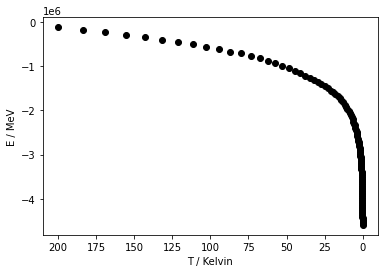

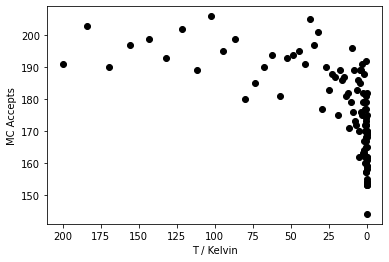

In [23]:
plt.close('all')
plt.figure()
plt.plot(T_plot,E_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('E / MeV')
plt.show()
plt.close('all')
plt.figure()
plt.plot(T_plot,MCA_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('MC Accepts')
plt.show()

In [24]:
starttime = time()

MCS = 300 # MC steps per temperature
J = 100 # meV
T = 200 # Kelvin
T_p = 0.97
kB = 8.617e-2 # meV/K

MCA_plot = []
T_plot = []
E_plot = []

# set up the sites
lat = lattice(50,50,50) # set up the size of lattice
lat.populatesites()     # Assign each site a coordinate
lat.initialisespins()   # Assign each site a random spin
E_0 = lat.gettotalenergy1(J) # get initial total energy of the system
E_t = E_0

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    
    for i in range(MCS):
        fs = lat.pickrandomsite() # pick a random site to flip its spin
        lat.filpspin(fs) # flip spin
        dE = lat.sites[fs].getdeltaexchangeenergy(J)*2

        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_t += dE
            MCA += 1 # MC Accepts
            
        else:
            lat.filpspin(fs) # flip the spin back
    
    print('%.2f  %d' %(T, MCA))
    MCA_plot.append(MCA)
    T_plot.append(T)
    E_plot.append(E_t)
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))

200.00  206
194.00  194
188.18  203
182.53  188
177.06  191
171.75  201
166.59  184
161.60  210
156.75  196
152.05  191
147.48  179
143.06  204
138.77  194
134.61  186
130.57  201
126.65  193
122.85  195
119.17  181
115.59  193
112.12  189
108.76  185
105.50  186
102.33  193
99.26  194
96.28  175
93.39  173
90.59  180
87.88  190
85.24  195
82.68  168
80.20  190
77.80  198
75.46  172
73.20  187
71.00  178
68.87  196
66.81  173
64.80  180
62.86  169
60.97  186
59.14  188
57.37  175
55.65  173
53.98  180
52.36  189
50.79  180
49.26  171
47.79  170
46.35  176
44.96  169
43.61  174
42.30  179
41.04  165
39.80  171
38.61  182
37.45  159
36.33  169
35.24  171
34.18  163
33.16  176
32.16  175
31.20  182
30.26  173
29.35  162
28.47  171
27.62  160
26.79  166
25.99  177
25.21  171
24.45  157
23.72  164
23.01  174
22.31  157
21.65  168
21.00  163
20.37  168
19.76  159
19.16  160
18.59  173
18.03  174
17.49  182
16.96  177
16.46  167
15.96  172
15.48  168
15.02  155
14.57  179
14.13  165
13.71  17

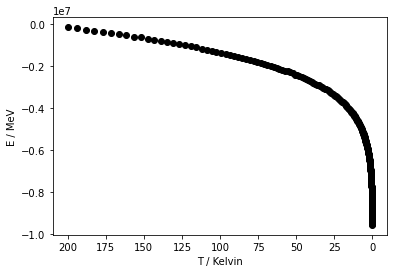

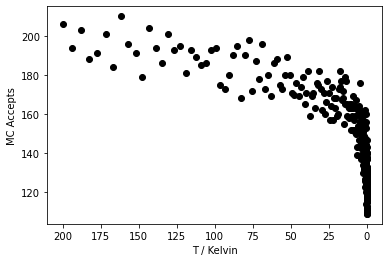

In [25]:
plt.close('all')
plt.figure()
plt.plot(T_plot,E_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('E / MeV')
plt.show()
plt.close('all')
plt.figure()
plt.plot(T_plot,MCA_plot,'ok')
plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('MC Accepts')
plt.show()